<h2><center><font color='blue'> Calculation of Well Head Protection Areas using Capture Zone Analysis </center></h2>

<h3><font color='teal'><center> Venki Uddameri, Ph.D., P.E.

<hr>

The use of Theis solution for capture zone analysis does not account for the impacts of regional groundwater flow gradients.  As such, other tools for better delineation of capture zones are available.  A schematic description of the capture zones is shown below




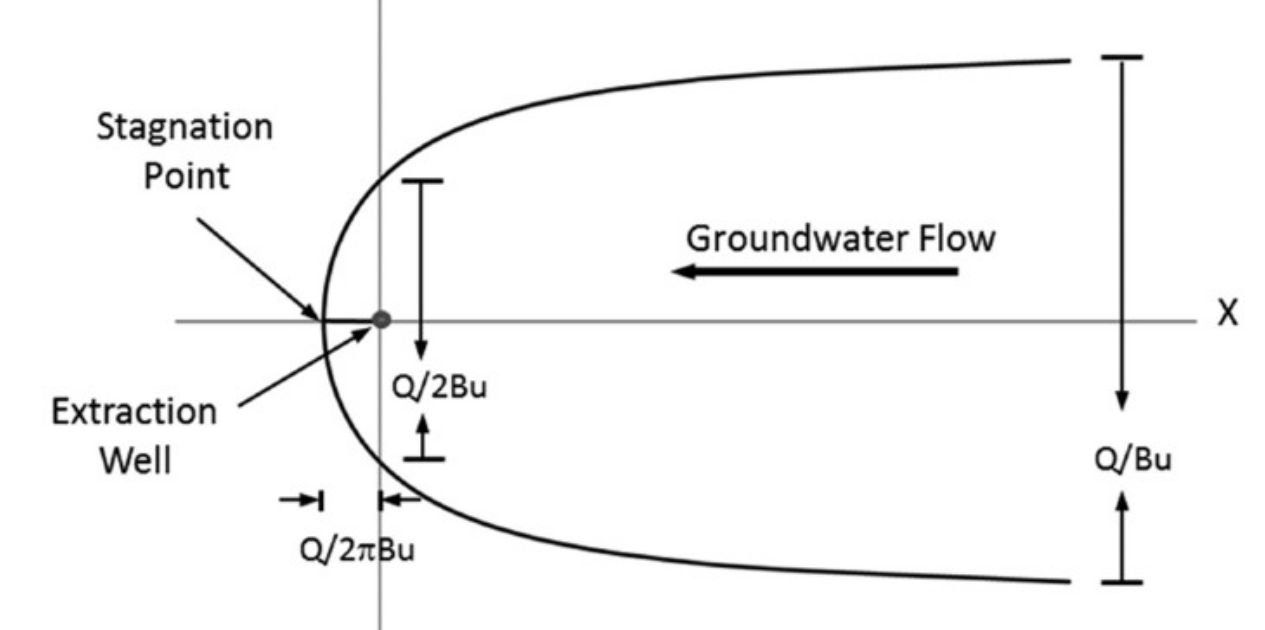

The figure above assumes the well is at a location (0,0).  The stagnation point refers to the point on the X-axis (downgradient of the flow) till which the pumping effects are felt.  The maximum width of the cpature zone along the Y-axis is also given.  We can also obtain the outer curve of the capture zone using the following equations.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

Where, U is the Darcy velocity (K.i) (ft/d); K is the hydraulic conductivity (ft/d); i is regional groundwater flow gradient.  Q is the pumping rate (ft$^3$/d); B is the aquifer thickness.  Note the product BU can also be written as the product Ti (where T is the aquifer transmissivity ft$^2$/d).  Note any set of consistent units can be used.  **If Albert Equal Area Conic** projection is used then the use of m for length dimension may come handy.  

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>
<li> Select projection to use.  Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>
<li> Select the Well Location (get lat-lon coordinates) convert to AEA projection </li>
<li> Extract Transmissivity values at the well (from interpolated T gpkg file) </li>
<li> Obtain the mean water levels (computed earlier) for wells in a gpkg fle </li>
<li> Convert the meam water levels file to AEA projection and compute X and Y coordinates </li>
<li> Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y </li>
<li> Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient </li>
<li> Compute the capture zone polygon in model coordinates (well is at 0,0) </li>
<li> Convert the capture zone polygon to AEA projection coordinates use suitable transformation </li>
<li> Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</li>
<li> Create a shapely polygon (object) of the capture zone.  Export to a gpkg file
<li> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.
</ol>

<h4> Import Libraries

In [18]:
# Import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib_map_utils as mu # To draw north arrow
import statsmodels.api as sm
from matplotlib_scalebar.scalebar import ScaleBar # To draw scalebar

<h4> Set Working Directory

In [20]:
path = 'C:/Users/asidd/OneDrive/Desktop/GIS_Data/TX_Waterwell'
os.chdir(path)

<h4>Required File 

<h4>Set Working Directory

In [23]:
fname1 = 'PWells_GAM.gpkg'
fname2 = 'JeffersonWGS84.gpkg'
fname3 = 'GCMeanWL.csv'
fname4 = 'SelPWells.csv'

In [24]:
# Read the GeoPackage file
Tval = gpd.read_file(fname1)

# Set the CRS for the GeoDataFrame, e.g., WGS84 (EPSG:4326)
Tval.set_crs(epsg=4326, inplace=True)

# Convert the CRS to Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
Tval = Tval.to_crs(epsg=6350)

# Display the GeoDataFrame
print(Tval)

   StateWellNumber     County  LongitudeDD  LatitudeDD  \
0          6154901  Jefferson   -94.266112   30.134722   
1          6154905  Jefferson   -94.271389   30.159167   
2          6161602  Jefferson   -94.407223   30.073611   
3          6162303  Jefferson   -94.275555   30.089167   
4          6162305  Jefferson   -94.291667   30.096389   
5          6301301  Jefferson   -93.908612   29.968055   
6          6423201  Jefferson   -94.199722   29.742500   
7          6423302  Jefferson   -94.164167   29.741389   
8          6424502  Jefferson   -94.072778   29.667778   

   LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  \
0  Interpolated From Topo Map       21.0       23.100000      6.900000   
1  Interpolated From Topo Map      572.0      -25.338571     51.338571   
2  Interpolated From Topo Map      300.0       29.300000      6.700000   
3  Interpolated From Topo Map      102.0       30.000000      8.000000   
4  Interpolated From Topo Map      208.0       31

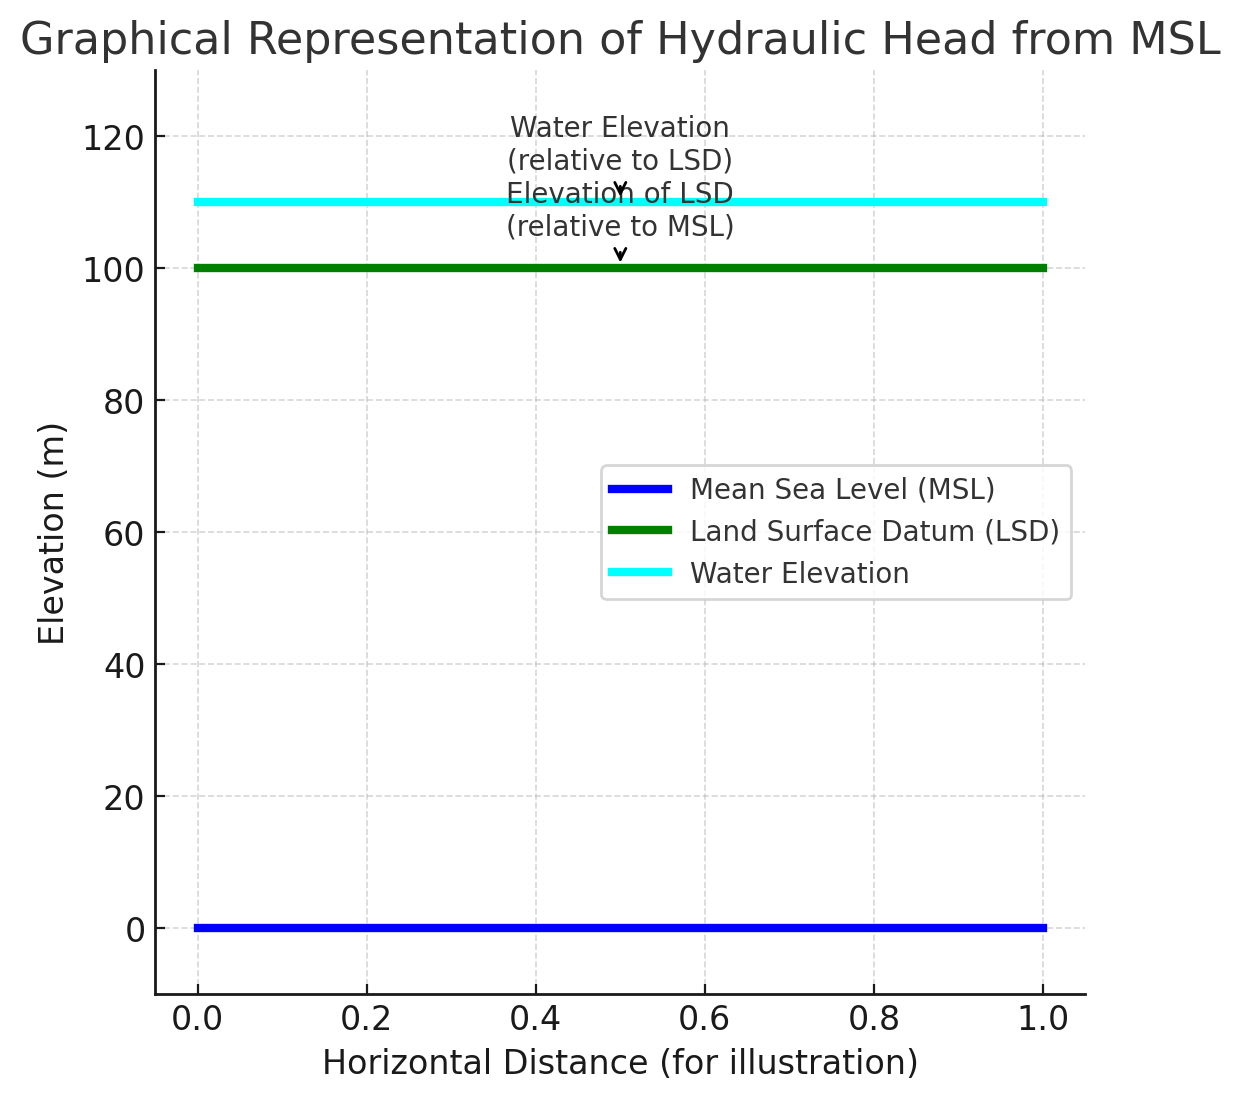

In [26]:
# Conversion factor from ft²/day to m2/day,conversion_factor = 0.0929
Tval['T_SQMPDay'] = Tval['T_SQFTDay'] * 0.0929
# Calculate Hydraulic Head assuming 'WaterElevation' and 'DepthFromLSD' provide enough info
Tval['HydraulicHead(MSL)'] = Tval['WaterElevation'] + Tval['DepthFromLSD']

In [27]:
Tval.columns

Index(['StateWellNumber', 'County', 'LongitudeDD', 'LatitudeDD',
       'LandSurfaceElevationMethod', 'WellDepth', 'WaterElevation',
       'DepthFromLSD', 'T_SQFTDay', 'T_GPD_ft', 'top_1', 'bot_1', 'bot_2',
       'bot_3', 'bot_4', 'bot_5', 'bot_6', 'geometry', 'T_SQMPDay',
       'HydraulicHead(MSL)'],
      dtype='object')

In [28]:
WID = 6162305# Selected Well Id for my selected well
Selwell = Tval.loc[Tval.StateWellNumber==WID]
Selwell

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,T_SQFTDay,T_GPD_ft,top_1,bot_1,bot_2,bot_3,bot_4,bot_5,bot_6,geometry,T_SQMPDay,HydraulicHead(MSL)
4,6162305,Jefferson,-94.291667,30.096389,Interpolated From Topo Map,208.0,31.0,8.0,3315,24797,11.6023,-3.3977,-431.0,-818.0,-1030.0,-1596.809,-2295.0,POINT (164452.693 781550.465),307.9635,39.0


In [29]:
# Load the CSV file
fname3 = 'GCMeanWL.csv'
df = pd.read_csv(fname3)

# Use 'LongitudeDD' and 'LatitudeDD' columns to create geometry
geometry = [Point(xy) for xy in zip(df['LongitudeDD'], df['LatitudeDD'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the initial CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert the CRS to Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
gdf = gdf.to_crs(epsg=6350)

# Extract the transformed coordinates (X, Y) from the GeoDataFrame
gdf['LON_AEA'] = gdf.geometry.x
gdf['LAT_AEA'] = gdf.geometry.y

# Calculate 'Hydraulic_Head_MSL' using the columns 'WaterElevation' and 'DepthFromLSD'
gdf['Hydraulic_Head_MSL'] = gdf['WaterElevation'] + gdf['DepthFromLSD']

gdf.head(5)



,Unnamed: 0,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,geometry,LON_AEA,LAT_AEA,Hydraulic_Head_MSL
0,0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,POINT (166834.847 785849.276),166834.846987,785849.276114,30.0
1,1,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0,-17.178889,45.178889,POINT (166304.523 788553.616),166304.522818,788553.615566,28.0
2,2,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0,-17.287143,44.287143,POINT (166379.619 788832.556),166379.619326,788832.555902,27.0
3,3,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,POINT (166277.794 788553.163),166277.793526,788553.162588,26.0
4,7,6155701,Jefferson,-94.213889,30.130555,Interpolated From Topo Map,68.0,27.000000,9.000000,POINT (171867.858 785479.863),171867.858370,785479.863195,36.0


In [30]:
# Prepare the independent variables (X) and add a constant for the intercept
X = gdf[['LON_AEA', 'LAT_AEA']]
X = sm.add_constant(X)  # Adds a constant term (intercept) to the model

# Dependent variable (Y)
Y = gdf['Hydraulic_Head_MSL']

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())

# Extract the coefficients
c, a, b = model.params

# Compute the predicted Hydraulic Head values
gdf['Predicted_Hydraulic_Head_MSL'] = model.predict(X)

# Save the updated GeoDataFrame as a CSV file
gdf.to_csv('transformed_data_with_statsmodels_regression.csv', index=False)


                            OLS Regression Results                            
Dep. Variable:     Hydraulic_Head_MSL   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     146.7
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           1.15e-38
Time:                        10:51:47   Log-Likelihood:                -631.25
No. Observations:                 185   AIC:                             1269.
Df Residuals:                     182   BIC:                             1278.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -267.3913     34.456     -7.760      0.0

In [31]:
a,b,c

(-0.00047479933901324915, 0.00048432300296773233, -267.3912962552759)

In [32]:
gdf.head()

,Unnamed: 0,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,geometry,LON_AEA,LAT_AEA,Hydraulic_Head_MSL,Predicted_Hydraulic_Head_MSL
0,0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,POINT (166834.847 785849.276),166834.846987,785849.276114,30.0,34.000510
1,1,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0,-17.178889,45.178889,POINT (166304.523 788553.616),166304.522818,788553.615566,28.0,35.562081
2,2,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0,-17.287143,44.287143,POINT (166379.619 788832.556),166379.619326,788832.555902,27.0,35.661523
3,3,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,POINT (166277.794 788553.163),166277.793526,788553.162588,26.0,35.574553
4,7,6155701,Jefferson,-94.213889,30.130555,Interpolated From Topo Map,68.0,27.000000,9.000000,POINT (171867.858 785479.863),171867.858370,785479.863195,36.0,31.431924


In [33]:
# Given parameters
import numpy as np
Pop = 20000
pcu = 135  # gallons/d/capita
Q = Pop * pcu * 0.0037854117840007 # Pumping rate in cubic meter per day (m³/d), Conversion Factor 0.0037854117840007 from Gallor to Cubic Meter 
i = np.sqrt(a**2 + b**2)  # Resultant gradient
T = list(Selwell.T_SQMPDay)  # T values in cubic meter per day
T = np.array(T)  # Convert the list to a numpy array
Ti = T * i       # Element-wise multiplication

# Calculate the stagnation point on the X-axis
pi = np.pi
x_s = -Q / (2 * pi * Ti)

# Calculate the y-value at the extraction well
Y0 = (Q/(4*Ti)), -(Q/(4*Ti))

# Calculate the maximum width of the capture zone along the Y-axis
y_max = (Q/(2*Ti)), -(Q/(2*Ti))

# Print the result
print(f"Stagnation point (x_s): {x_s} m")
print(f"Maximum width of the capture zone (y_max): {y_max} m")
print(f"Y-value at the extraction well (Y_at the well): {Y0} m")
print(f"T : {T} m^3/day")
print(f"i : {i}")
print(f"Q : {Q} m^3/day")
Ti

Stagnation point (x_s): [-7787.84609233] m
Maximum width of the capture zone (y_max): (array([24466.24007094]), array([-24466.24007094])) m
Y-value at the extraction well (Y_at the well): (array([12233.12003547]), array([-12233.12003547])) m
T : [307.9635] m^3/day
i : 0.0006782353452387308
Q : 10220.611816801891 m^3/day


array([0.20887173])

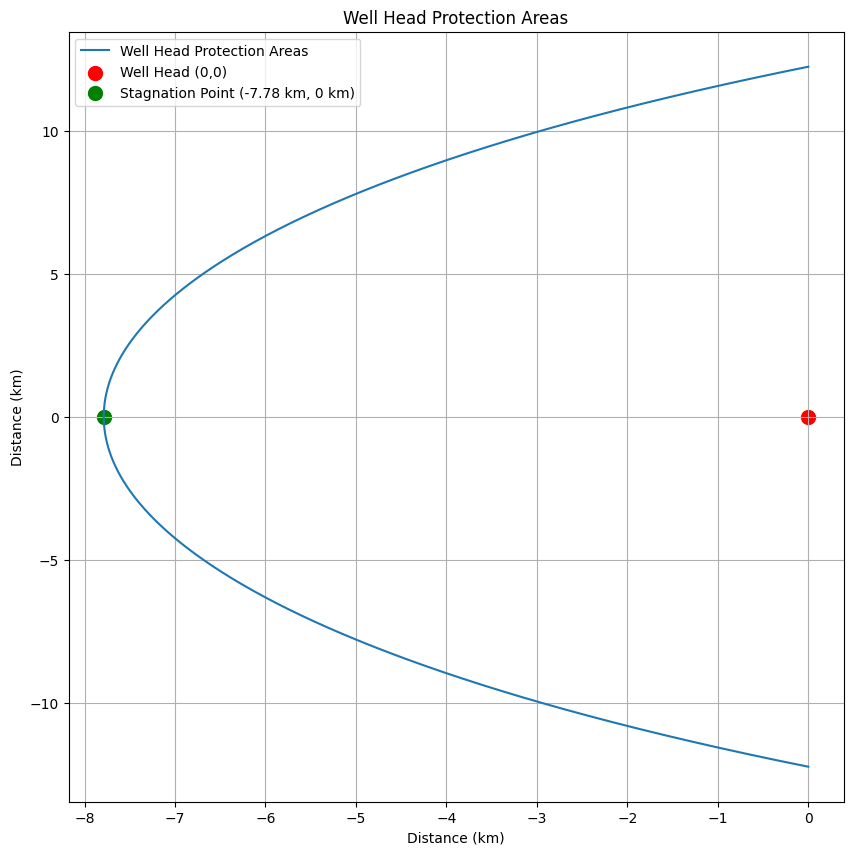

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
Ti = 0.20887173
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters and convert to kilometers for plotting
y = np.linspace(-12233.12003547, 12233.12003547, 1000)  # y in meters
y_km = y / 1000  # Convert y to kilometers

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * Ti * y) / Q)  # x in meters
x_km = x / 1000  # Convert x to kilometers

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_km, y_km, label='Well Head Protection Areas')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Well Head Protection Areas')

# Marking the Well Head at (0,0)
plt.scatter(0, 0, color='red', s=100, label='Well Head (0,0)')  # Well head in kilometers

# Marking the Stagnation Point, converting -8229.32 meters to kilometers
plt.scatter(-7.78, 0, color='green', s=100, label='Stagnation Point (-7.78 km, 0 km)')  # Stagnation point in kilometers

plt.grid(True)
plt.legend()
plt.show()

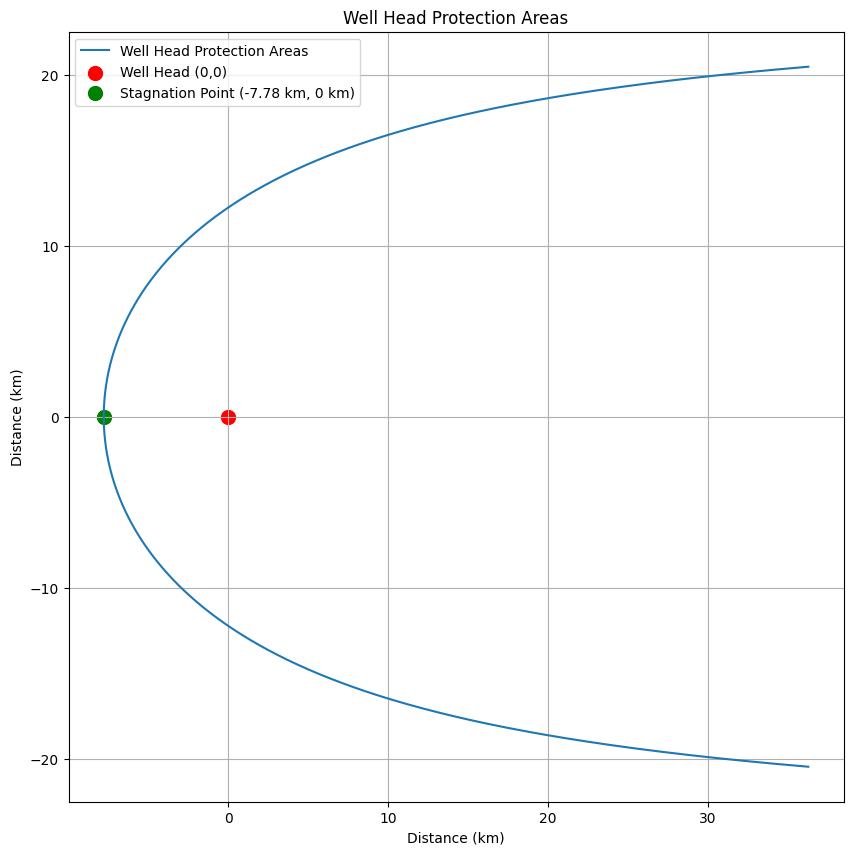

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
Ti = 0.20887173
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters and convert to kilometers for plotting
y = np.linspace(-20466.24007094, 20466.24007094, 1000)  # y in meters
y_km = y / 1000  # Convert y to kilometers

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * Ti * y) / Q)  # x in meters
x_km = x / 1000  # Convert x to kilometers

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_km, y_km, label='Well Head Protection Areas')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Well Head Protection Areas')

# Marking the Well Head at (0,0)
plt.scatter(0, 0, color='red', s=100, label='Well Head (0,0)')  # Well head in kilometers

# Marking the Stagnation Point, converting -8229.32 meters to kilometers
plt.scatter(-7.78, 0, color='green', s=100, label='Stagnation Point (-7.78 km, 0 km)')  # Stagnation point in kilometers

plt.grid(True)
plt.legend()
plt.show()

<h4>Recheck Hydraulic Gradi</h4>

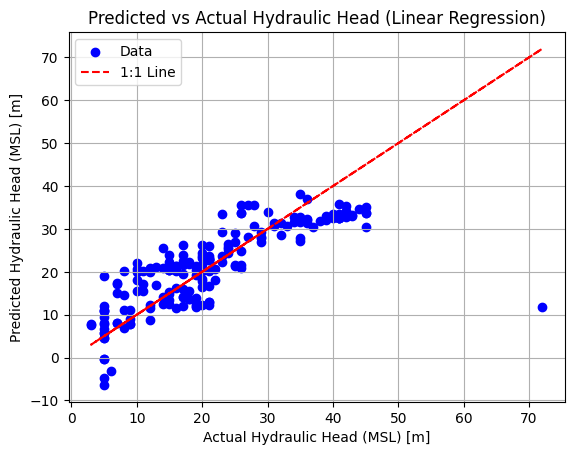

Equation of the groundwater flow plane: H = -0.000475 * X + 0.000484 * Y + -267.391289


In [37]:
from scipy.optimize import curve_fit

# Extract the data for regression
x_data = gdf['LON_AEA'].values
y_data = gdf['LAT_AEA'].values
z_data = gdf['Hydraulic_Head_MSL'].values

# Define a linear function for the groundwater flow plane
def fit_function(X, a, b, c):
    return a * X[0] + b * X[1] + c

# Prepare data for curve fitting
X_data = np.vstack((x_data, y_data))

# Perform curve fitting using scipy's curve_fit
params, _ = curve_fit(fit_function, X_data, z_data)

# Extract the parameters
a, b, c = params

# Compute the predicted Hydraulic Head values
predicted_z = fit_function(X_data, a, b, c)

# Plot the actual vs. predicted Hydraulic Head
plt.scatter(z_data, predicted_z, color='blue', label='Data')
plt.plot(z_data, z_data, color='red', linestyle='--', label='1:1 Line')  # Ideal line
plt.xlabel('Actual Hydraulic Head (MSL) [m]')
plt.ylabel('Predicted Hydraulic Head (MSL) [m]')
plt.title('Predicted vs Actual Hydraulic Head (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

# Print the equation of the fitted plane
print(f"Equation of the groundwater flow plane: H = {a:.6f} * X + {b:.6f} * Y + {c:.6f}")



In [38]:
#https://sci-hub.st/10.1007/s10040-016-1518-4 
#HydrogeoEstimatorXL: an Excel-based tool for estimating hydraulic gradient magnitude and direction J. F. Devlin1 & P. C. Schillig2
# Extract the necessary columns: Longitude, Latitude, and Hydraulic Head
x = gdf['LON_AEA'].values
y = gdf['LAT_AEA'].values
H = gdf['Hydraulic_Head_MSL'].values

# Construct the matrix and vector for the system of equations
X = np.column_stack((x, y, np.ones(len(x))))  # The matrix [x, y, 1]
D = H  # The vector [Hydraulic Head values]

# Solve for the coefficients A, B, C
A, B, C = np.linalg.lstsq(X, D, rcond=None)[0]

# Calculate the gradients
gradient_x = -A / C
gradient_y = -B / C
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# Output the results
print("Gradient in the x-direction:", gradient_x)
print("Gradient in the y-direction:", gradient_y)
print("Magnitude of the Hydraulic Gradient:", gradient_magnitude)

Gradient in the x-direction: -1.7756723785057195e-06
Gradient in the y-direction: 1.8112893342099413e-06
Magnitude of the Hydraulic Gradient: 2.5364899857895857e-06


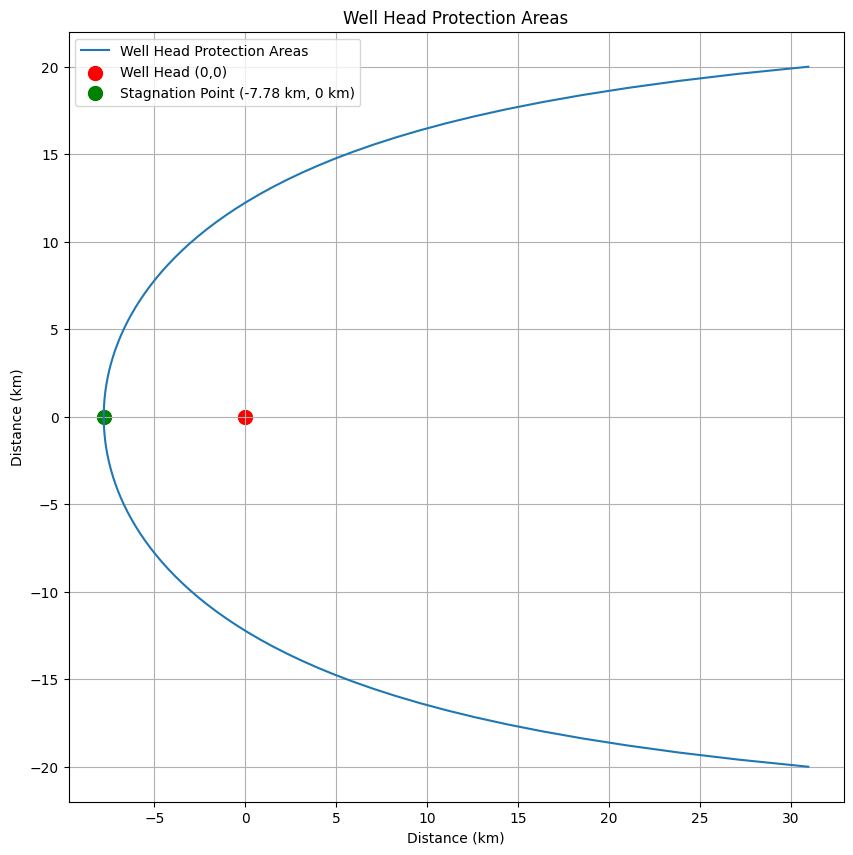

array([30964.48262797, 27139.47939841, 23866.87714888, 21030.71889932,
       18545.81655103, 16348.17115952, 14388.76341177, 12629.40760621,
       11039.91106509,  9596.08331976,  8278.31254847,  7070.52922873,
        5959.43944093,  4933.94935923,  3984.72751966,  3103.86785475,
        2284.62742805,  1521.22023479,   808.65356556,   142.59702426,
        -480.72315627, -1064.61002106, -1611.96620689, -2125.35186439,
       -2607.03265929, -3059.0197751 , -3483.10342457, -3880.88106038,
       -4253.78123112, -4603.08384003, -4929.93741563, -5235.37388772,
       -5520.32126987, -5785.61457667, -6032.00524534, -6260.16928374,
       -6470.7143293 , -6664.18577147, -6841.0720654 , -7001.8093433 ,
       -7146.78541271, -7276.34321629, -7390.78381584, -7490.36895308,
       -7575.32323075, -7645.83595063, -7702.06263839, -7744.12627959,
       -7772.11828648, -7786.09921029, -7786.09921029, -7772.11828648,
       -7744.12627959, -7702.06263839, -7645.83595063, -7575.32323075,
      

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
Ti = 0.20887173
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define a reasonable y range to control extreme x values
y = np.linspace(-20000, 20000, 100)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * Ti * y) / Q)

# Filter out extreme x values
# Define a threshold to exclude values where x is too large or too small
#threshold = 1e10  # Threshold in meters
#valid_indices = np.isfinite(x) & (np.abs(x) < threshold)

# Filter x and y based on valid indices
#x_filtered = x[valid_indices]
#y_filtered = y[valid_indices]

# Convert x and y to kilometers for plotting
#x_km = x_filtered / 1000
#y_km = y_filtered / 1000

x_km = x/ 1000
y_km = y/ 1000


# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_km, y_km, label='Well Head Protection Areas')
#plt.plot(x, y, label='Well Head Protection Areas')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Well Head Protection Areas')

# Marking the Well Head at (0, 0)
plt.scatter(0, 0, color='red', s=100, label='Well Head (0,0)')

# Marking the Stagnation Point at (-7.78 km, 0 km)
plt.scatter(-7.78, 0, color='green', s=100, label='Stagnation Point (-7.78 km, 0 km)')

plt.grid(True)
plt.legend()
plt.show()
x


Theta in radians: -0.795327398237658
Theta in degrees: -45.56890325013827


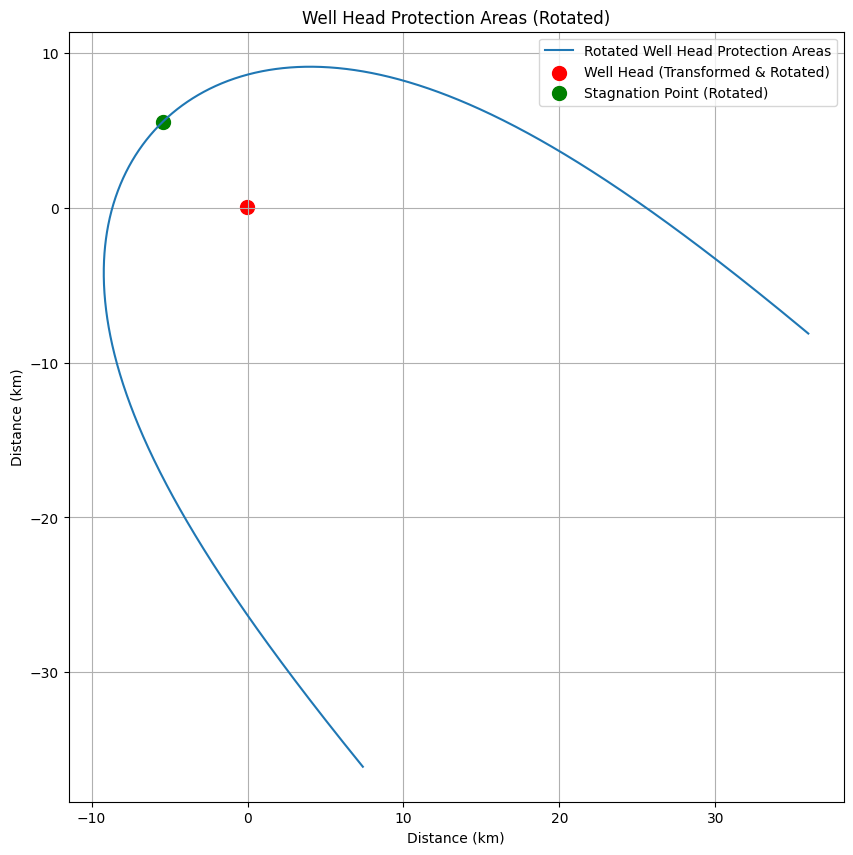

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

# Given values a and b
a = -0.00047479933901324915
b = 0.00048432300296773233

# Calculate theta using np.arctan
theta = np.arctan(b / a)

# Convert theta from radians to degrees if needed
theta_degrees = np.degrees(theta)

print("Theta in radians:", theta)
print("Theta in degrees:", theta_degrees)

# Constants
Ti = 0.20887173
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define a wide y range in meters
y = np.linspace(-20000, 20000, 1000)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * Ti * y) / Q)

# Filter out extreme x values (those that become excessively large)
valid_indices = np.abs(x) < 1e6  # Adjust the threshold as necessary
x = x[valid_indices]
y = y[valid_indices]

# Convert x and y to kilometers for plotting
x_km = x / 1000
y_km = y / 1000

# Initialize a transformer to convert coordinates
transformer = Transformer.from_crs("EPSG:6350","EPSG:4326", always_xy=True)

# Transform the well head point to EPSG:4326
well_head_x, well_head_y = transformer.transform(164452.693, 781550.465)

# Use the calculated theta in radians
theta = np.arctan(b / a)  # Ensure we're using the same theta from above

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Rotate the (x, y) coordinates
rotated_coords = np.dot(rotation_matrix, np.vstack((x_km, y_km)))
x_rotated = rotated_coords[0, :]
y_rotated = rotated_coords[1, :]

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_rotated, y_rotated, label='Rotated Well Head Protection Areas')
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.title('Well Head Protection Areas (Rotated)')

# Marking the Well Head at the transformed and rotated point
well_head_rotated = np.dot(rotation_matrix, np.array([well_head_x / 1000, well_head_y / 1000]))
plt.scatter(well_head_rotated[0], well_head_rotated[1], color='red', s=100, label='Well Head (Transformed & Rotated)')

# Marking the Stagnation Point at (-7.78 km, 0 km), also rotated
stagnation_point_rotated = np.dot(rotation_matrix, np.array([-7.78, 0]))
plt.scatter(stagnation_point_rotated[0], stagnation_point_rotated[1], color='green', s=100, label='Stagnation Point (Rotated)')

plt.grid(True)
plt.legend()
plt.show()



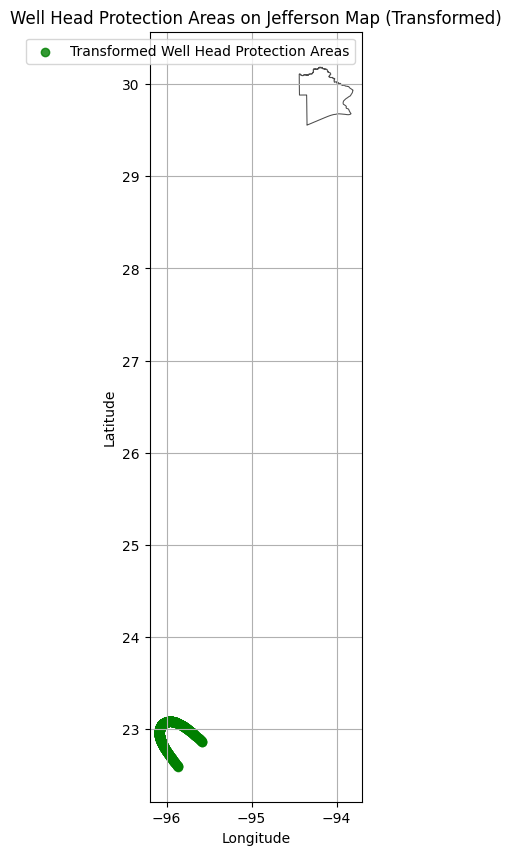

Transformed GeoPackage saved to: C:/Users/asidd/OneDrive/Desktop/GIS_Data/TX_Waterwell/WellHeadProtectionAreas_Transformed.gpkg


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

# Given values a and b
a = -0.00047479933901324915
b = 0.00048432300296773233

# Calculate theta using np.arctan
theta = np.arctan(b / a)

# Constants
Ti = 0.20887173
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define a wide y range in meters
y = np.linspace(-20853.1874121, 20853.1874121, 1000)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * Ti * y) / Q)

# Filter out extreme x values (those that become excessively large)
valid_indices = np.abs(x) < 1e6  # Adjust the threshold as necessary
x = x[valid_indices]
y = y[valid_indices]

# Convert x and y to kilometers for plotting
x_km = x / 1000
y_km = y / 1000

# Use the given well head coordinates in EPSG:6350
well_head_x = 164452.693
well_head_y = 781550.465

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Rotate the (x, y) coordinates
rotated_coords = np.dot(rotation_matrix, np.vstack((x_km, y_km)))
x_rotated = rotated_coords[0, :]
y_rotated = rotated_coords[1, :]

# Initialize a transformer to convert coordinates from EPSG:6350 to EPSG:4326
transformer = Transformer.from_crs("EPSG:6350", "EPSG:4326", always_xy=True)

# Transform the rotated coordinates
transformed_coords = [transformer.transform(x * 1000, y * 1000) for x, y in zip(x_rotated, y_rotated)]
lon_transformed, lat_transformed = zip(*transformed_coords)

# Convert the transformed coordinates to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(lon_transformed, lat_transformed)]
gdf_transformed = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Load the Jefferson map
fJeff = 'JeffersonWGS84.gpkg'
Jeff = gpd.read_file(fJeff)

# Plotting the Jefferson map with transformed coordinates
fig, ax = plt.subplots(figsize=(10, 10))
Jeff.plot(ax=ax, color='white', edgecolor='black', alpha=0.7, linewidth=0.75)

# Plot the transformed wellhead protection areas on the same ax
gdf_transformed.plot(ax=ax, color='green', alpha=0.8, label='Transformed Well Head Protection Areas')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Well Head Protection Areas on Jefferson Map (Transformed)')
ax.grid()
ax.legend()

# Show the plot
plt.show()

# Save the transformed GeoDataFrame to a new GeoPackage file
output_path = 'C:/Users/asidd/OneDrive/Desktop/GIS_Data/TX_Waterwell/WellHeadProtectionAreas_Transformed.gpkg'
gdf_transformed.to_file(output_path, driver='GPKG')

print(f"Transformed GeoPackage saved to: {output_path}")


In [42]:
gdf_transformed

,geometry
0,POINT (-95.86389 22.5914)
1,POINT (-95.86783 22.59585)
2,POINT (-95.87168 22.60021)
3,POINT (-95.87545 22.60448)
4,POINT (-95.87913 22.60867)
...,...
995,POINT (-95.59639 22.8747)
996,POINT (-95.59214 22.87104)
997,POINT (-95.5878 22.86729)
998,POINT (-95.58338 22.86346)


<h2>Limitation of Works:

In [44]:
# Print the result
print(f"Stagnation point (x_s): {x_s} m")
print(f"Maximum width of the capture zone (y_max): {y_max} m")
print(f"Y-value at the extraction well (Y_at the well): {Y0} m")
print(f"T : {T} m^3/day")
print(f"i : {i}")
print(f"Q : {Q} m^3/day")
Ti

Stagnation point (x_s): [-7787.84609233] m
Maximum width of the capture zone (y_max): (array([24466.24007094]), array([-24466.24007094])) m
Y-value at the extraction well (Y_at the well): (array([12233.12003547]), array([-12233.12003547])) m
T : [307.9635] m^3/day
i : 0.0006782353452387308
Q : 10220.611816801891 m^3/day


0.20887173

1. Hydralic Gradient: As the boundary equation dominate the value Ti, so gradienct should be correct, in this calcuation we found the value of hydralic gradient is 0.000678. But this value ypically, flow gradients in Texas aquifers range from 0.001 (flat gradient) to 0.01 (steep gradient), depending on factors such as the aquifer type, topography, and subsurface conditions. Our value gradient is found small camparatively typical range of gradient that the boundary x,y found to high.
2. It has found that, from the bounday equation given is a funtion of tangent value where the argument of the tangent function reaches values that make the tangent function very large or undefined.
3. Our Ymax value is found 24.46km which is a large value and with respect to this value the x value from the boundary equation found very high. But if we reduce this value to 20km the capture zone plot and fit vey well.